In [1]:
%load_ext autoreload
%autoreload 2

In [60]:
import pandas as pd
import Levenshtein
from pathlib import Path
import pickle as pk
import numpy as np
import pickle as pk

from src.analysis.fraudulous import filter_out, detect_honey_frauders, detect_repeat_frauders
from src.constants import HONEYPOTS, EMOJI_DATASET_DIR, HONEYPOTS, EM_VOC_COUNT, EMOJI_DATASET_EXPORT_DIR, EMOJI_DATASET_EXPORT_PATH
from src.analysis.postprocessing import (scrap_form_results, get_emojis_voc_counts, write_emojis_voc_counts,
                                         display_whole_dir, generate_production_format, build_worker_info_table)
from src.analysis.fraudulous import study_outsiders
import matplotlib.pyplot as plt

In [4]:
# create the worker infos table
worker_infos = build_worker_info_table(input_directory=EMOJI_DATASET_DIR,
                                       output_dir=EMOJI_DATASET_EXPORT_DIR)

# Postprocessing

<div class="alert alert-success">
Postprocessing of data gathered from mturk/gform
</div>

## Frauder Detection

In [41]:
# List of all df in child directories of dataset dir
form_dfs = scrap_form_results(EMOJI_DATASET_DIR)

N = sum([df.shape[0] for df in form_dfs])
print(f"Initial data shape: {N} rows")

#### Repeat frauders

In [55]:
n_frauders, form_dfs = filter_out(
    form_dfs, detect_repeat_frauders, 0.8, verbose=True, display_=False)

Discarded 1 rows


#### Honeypots frauders

In [58]:
honeypots = HONEYPOTS
dist_lshtein = 3

# Uncomment the cell to check for refused honeypots words
# study_outsiders(form_dfs,HONEYPOTS,dist_lshtein)

n_honey, form_dfs = filter_out(
    form_dfs, detect_honey_frauders, HONEYPOTS, dist_lshtein=4, verbose=True)

## Visualizing the vocabulary 

<div class="alert alert-success">
We compute the value counts of every word for each emoji and save it to a file.
</div>

In [59]:
em2vocab = get_emojis_voc_counts(EMOJI_DATASET_DIR)
write_emojis_voc_counts(em2vocab, EM_VOC_COUNT)

## Generating final format

In [64]:
tot_df = generate_production_format(form_dfs, EMOJI_DATASET_EXPORT_PATH)

100%|██████████| 133/133 [00:03<00:00, 36.13it/s]


In [105]:
def plot_hist_num_anot_per_emoji(tot_df):
    """
    """
    fig,axes = plt.subplots(1,2,figsize=(15,5))
    
    ax = axes[0]
    val_counts = tot_df['emoji'].value_counts()
    val_counts.hist(ax=ax)
    ax.set_xlabel("Number of annotations")
    ax.set_ylabel("Number of emojis")
    ax.set_title("Histogram of annotations number per emojis")
    
    ax = axes[1]
    voc_size_per_emoji = tot_df.groupby('emoji')['word'].agg(lambda x: len(set(x)))
    voc_size_per_emoji = voc_size_per_emoji / val_counts
    voc_size_per_emoji.hist(ax=ax)
    ax.set_xlabel('Size of vocabulary/word')
    ax.set_ylabel('Number of emojis')
    ax.set_title('Histogram of normalized vocabulary size')

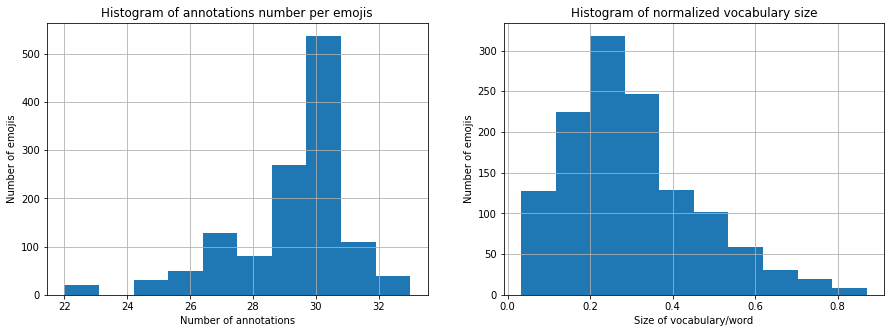

In [106]:
plot_hist_num_anot_per_emoji(tot_df)